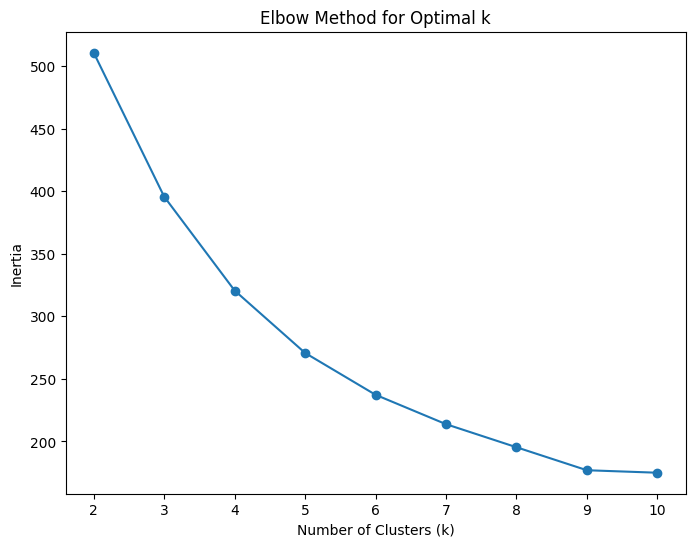

Davies-Bouldin Index: 1.1597841843464511


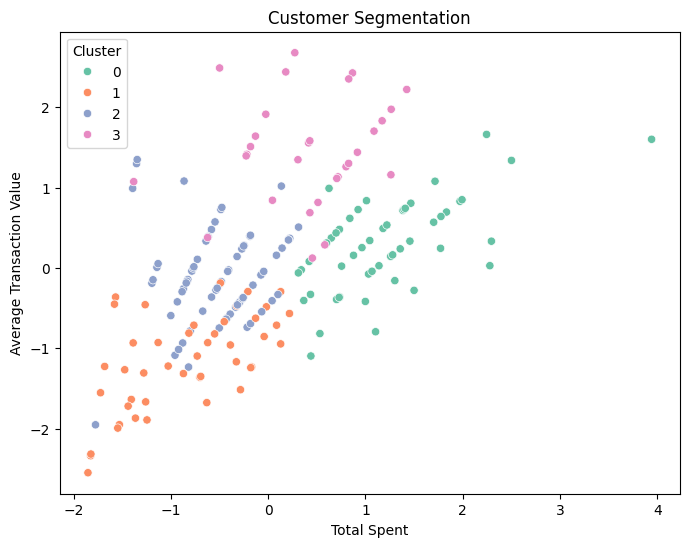

Cluster Centers:
[[ 1.21030096  1.17248129  0.28919782  0.21200331]
 [-0.84884404 -0.26481149 -1.15513597 -1.26209197]
 [-0.51355763 -0.51183096 -0.09891594  0.16360479]
 [ 0.40794937 -0.40668934  1.46882599  1.13301406]]
Cluster Sizes:
Cluster
2    72
0    52
1    45
3    30
Name: count, dtype: int64


In [13]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers_df = pd.read_csv('/Users/kartikaursang/Downloads/Customers.csv')
products_df = pd.read_csv('/Users/kartikaursang/Downloads/Products.csv')
transactions_df = pd.read_csv('/Users/kartikaursang/Downloads/Transactions.csv')

# Merging the data to get transaction details along with customer information
transactions_df = transactions_df.merge(customers_df[['CustomerID', 'Region']], on='CustomerID', how='left')
transactions_df = transactions_df.merge(products_df[['ProductID', 'Category', 'Price']], on='ProductID', how='left')

# Feature Engineering: Aggregating customer transactions
customer_transactions = transactions_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    avg_quantity=('Quantity', 'mean'),
    region=('Region', 'first')
).reset_index()

# Encoding categorical features
customer_transactions = pd.get_dummies(customer_transactions, columns=['region'], drop_first=True)

# Standardizing the numerical features
scaler = StandardScaler()
numerical_features = ['total_spent', 'total_transactions', 'avg_transaction_value', 'avg_quantity']
customer_transactions[numerical_features] = scaler.fit_transform(customer_transactions[numerical_features])

# Choosing the number of clusters (k) using the Elbow method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_transactions[numerical_features])
    inertia.append(kmeans.inertia_)

# Plotting the Elbow method to visualize optimal k
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Choosing optimal k (let's assume k=4 based on the Elbow method)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
customer_transactions['Cluster'] = kmeans.fit_predict(customer_transactions[numerical_features])

# Calculating the Davies-Bouldin Index
db_index = davies_bouldin_score(customer_transactions[numerical_features], customer_transactions['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualizing the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_transactions['total_spent'], y=customer_transactions['avg_transaction_value'], hue=customer_transactions['Cluster'], palette='Set2')
plt.title('Customer Segmentation')
plt.xlabel('Total Spent')
plt.ylabel('Average Transaction Value')
plt.legend(title='Cluster')
plt.show()

# Saving clustering results to a CSV file
customer_transactions[['CustomerID', 'Cluster']].to_csv('FirstName_LastName_Clustering.csv', index=False)

# Displaying cluster centers
print(f'Cluster Centers:\n{kmeans.cluster_centers_}')

# Additional metrics: Cluster sizes
cluster_sizes = customer_transactions['Cluster'].value_counts()
print(f'Cluster Sizes:\n{cluster_sizes}')
